In [2]:
!pip install transformers tweet-preprocessor

     |████████████████████████████████| 1.3MB 5.0MB/s 
     |████████████████████████████████| 2.9MB 19.4MB/s 
     |████████████████████████████████| 890kB 28.8MB/s 
     |████████████████████████████████| 1.1MB 43.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=9e4c99d90904c4fda3bf220632035e0e2152f9110441e0e851efcc80d83456ec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
from transformers import BertTokenizer, BertForSequenceClassification
import preprocessor as p # tweet-preprocessor
import nltk
import re
import seaborn as sns

In [6]:
dataset = pd.read_csv('/content/drive/MyDrive/Copy of tweets_3k.csv', index_col=0)
dataset.head()

,Created-At,From-User-Id,To-User-Id,Language,Retweet-Count,PartyName,Id,Score,Scoring String,Negativity,Positivity,Uncovered Tokens,Total Tokens,State,Text
0,2020-10-05 13:48:00,267405095,-1,en,1264.0,Democrats,1313068582805270529,1.487179,actively (0.33) win (0.72) party (0.44),0.0,1.487179,26,29,Arizona,"RT @IngrahamAngle: Reminder: China, still acti..."
1,2020-09-10 04:25:00,29928823,-1,en,105.0,Republicans,1303867078458445826,1.307692,smart (0.44) smart (0.44) smart (0.44),0.0,1.307692,24,27,North Carolina,RT @MsAvaArmstrong: Smart suburban women WILL ...
2,2020-07-13 07:50:00,13165482,-1,en,538.0,Republicans,1282537894121484288,1.179487,trust (0.59) trust (0.59),0.0,1.179487,30,32,Texas,RT @AynRandPaulRyan: 26% of voters trust Trump...
3,2020-11-05 06:48:00,479964312,-1,en,70136.0,Democrats,1324196851034345472,1.564103,supporters (0.49) like (0.38) won (0.69),0.0,1.564103,19,22,Iowa,RT @Vic_Goes: Tr*mp supporters really abt to b...
4,2020-08-20 04:11:00,987817704072495104,-1,en,16267.0,Democrats,1296253496061120514,1.076923,proud (0.54) proud (0.54),0.0,1.076923,29,31,Utah,RT @NaomiBiden: I am proud to be your granddau...


States: 50


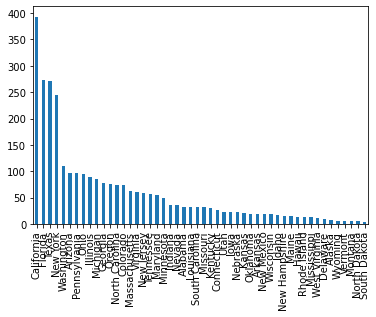

In [7]:
print(f"States: {dataset['State'].nunique()}")
dataset["State"].value_counts().plot.bar()

### Build dataset for classification

In [8]:
dataset_final = dataset.copy()

def buildLabels(row):
  if row["Score"] < 0:
    return "Anti" + row["PartyName"]
  else:
    return "Pro" + row["PartyName"]

def cleanTweet(row):
  tweet = row["Text"]
  tweet = str(p.clean(tweet))
  tweet = re.sub(r'[^\w\s]', '', tweet) # punctuation
  tweet = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", tweet) # numbers
  return tweet

  
dataset_final["y"] = dataset_final.apply(lambda row: buildLabels(row), axis=1)
dataset_final["clean_text"] = dataset_final.apply(lambda row: cleanTweet(row), 
                                                  axis=1)

In [9]:
dataset_final.drop(columns=['Created-At', 'From-User-Id', 'To-User-Id', 'Language',
                           'Retweet-Count', 'PartyName', 'Id', 'Score', 'Scoring String',
                           'Negativity', 'Positivity', 'Uncovered Tokens', 'Total Tokens'])

,State,Text,y,clean_text
0,Arizona,"RT @IngrahamAngle: Reminder: China, still acti...",ProDemocrats,Reminder China still actively covering up the...
1,North Carolina,RT @MsAvaArmstrong: Smart suburban women WILL ...,ProRepublicans,Smart suburban women WILL vote for TrumpSmart...
2,Texas,RT @AynRandPaulRyan: 26% of voters trust Trump...,ProRepublicans,of voters trust Trump for information on the...
3,Iowa,RT @Vic_Goes: Tr*mp supporters really abt to b...,ProDemocrats,Trmp supporters really abt to be like Biden o...
4,Utah,RT @NaomiBiden: I am proud to be your granddau...,ProDemocrats,I am proud to be your granddaughter every sin...
...,...,...,...,...
2961,Oregon,"RT @JoeBiden: If you're sick, struggling, or w...",AntiDemocrats,If youre sick struggling or worried about how...
2962,Ohio,RT @realDonaldTrump: Statement from the Presid...,ProRepublicans,Statement from the President on the Passing o...
2963,Texas,@realDonaldTrump We've been waiting for nearly...,ProRepublicans,Weve been waiting for nearly years for your wo...
2964,Nevada,RT @SteveSchmidtSES: There has been a traditio...,ProRepublicans,There has been a tradition that the outgoing ...


### Try out BERTForSequenceClassification to see how it goes

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      return_dict=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

(0.0, 128.0)

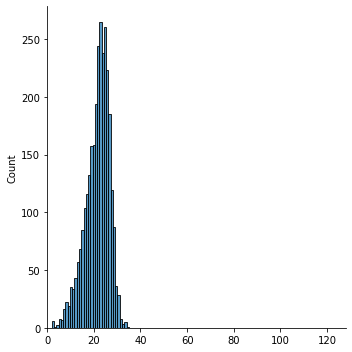

In [16]:
# find distribution of length of tokenized tweets
lens = []

for tweet in dataset_final.clean_text:
  tokens = tokenizer.encode(tweet, max_length=512)
  lens.append(len(tokens))

sns.displot(lens)
plt.xlim([0, 128])

In [ ]:
def buildBertInput(row):
  encoding = tokenizer.encode_plus(text=row["clean_text"],
                               add_special_tokens=True,
                               max_length=64,
                               pad_to_max_length=True,
                               return_attention_mask=True,
                               return_tensors='pt')
  
  